# Scene classification

**As, We want to design a system that can help a visually impaired person
know what is around them, I build a model to classify the scenes around him. As we were asked to consider only one object in image (i.e Image classification task), So I build a model to help visually impaired person to identify scenes around him.**

This Notebook shows how to classify images of different scenes.

## Import TensorFlow and other libraries

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers

Define some parameters for the loader:

In [30]:
batch_size = 32
img_height = 180
img_width = 180

## Create a dataset

In [31]:
## Downloaded the data from https://github.com/yan-ro/SceneClassifier/blob/master/hw5_data.zip
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  '../input/scene-data/hw5_data/train',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1500 files belonging to 15 classes.
Using 1200 files for training.


In [32]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  '../input/scene-data/hw5_data/train',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1500 files belonging to 15 classes.
Using 300 files for validation.


You can find the class names in the `class_names` attribute on these datasets. These correspond to the directory names in alphabetical order.

In [33]:
class_names = train_ds.class_names
print(class_names)

['Bedroom', 'Coast', 'Forest', 'Highway', 'Industrial', 'InsideCity', 'Kitchen', 'LivingRoom', 'Mountain', 'Office', 'OpenCountry', 'Store', 'Street', 'Suburb', 'TallBuilding']


In [34]:
len(class_names)

15

## Visualize the data

Here are the first 9 images from the training dataset.

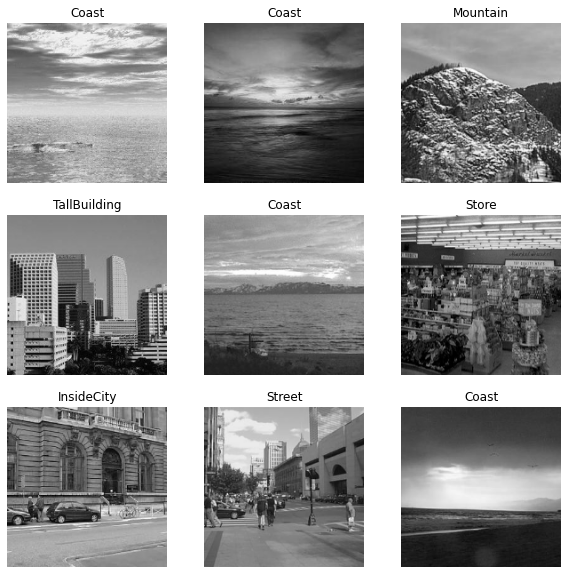

In [35]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [36]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


In [37]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general we should seek to make our input values small. Here, we will standardize values to be in the `[0, 1]` range by using a Rescaling layer.

In [38]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [39]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0071632904 0.9056413


# Create the model

The model consists of three convolution blocks with a max pool layer in each of them. There's a fully connected layer with 128 units on top of it that is activated by a `relu` activation function. 

In [41]:
num_classes = 15

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compile the model

In [13]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Model summary

View all the layers of the network using the model's `summary` method:

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

## Train the model

In [15]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
38/38 [==============================] - 3s 72ms/step - loss: 2.6728 - accuracy: 0.1200 - val_loss: 2.5235 - val_accuracy: 0.1800
Epoch 2/10
38/38 [==============================] - 1s 15ms/step - loss: 2.1513 - accuracy: 0.3175 - val_loss: 2.1617 - val_accuracy: 0.3200
Epoch 3/10
38/38 [==============================] - 1s 14ms/step - loss: 1.5731 - accuracy: 0.5100 - val_loss: 1.8776 - val_accuracy: 0.4300
Epoch 4/10
38/38 [==============================] - 1s 15ms/step - loss: 1.0536 - accuracy: 0.6700 - val_loss: 2.0315 - val_accuracy: 0.4467
Epoch 5/10
38/38 [==============================] - 1s 15ms/step - loss: 0.5147 - accuracy: 0.8583 - val_loss: 2.0402 - val_accuracy: 0.5033
Epoch 6/10
38/38 [==============================] - 1s 17ms/step - loss: 0.2801 - accuracy: 0.9225 - val_loss: 2.2919 - val_accuracy: 0.4367
Epoch 7/10
38/38 [==============================] - 1s 15ms/step - loss: 0.1406 - accuracy: 0.9542 - val_loss: 2.5382 - val_accuracy: 0.4900
Epoch 8/10
38

## Visualize training results

Plots of loss and accuracy on the training and validation sets.

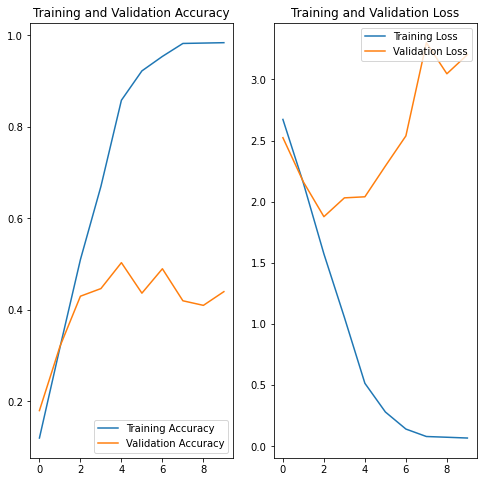

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

As you can see from the plots, training accuracy and validation accuracy are off by large margin and the model has achieved only around 40 - 50% accuracy on the validation set.

Let's look at what went wrong and try to increase the overall performance of the model.

## Overfitting

In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 40% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of overfitting

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process. Some are *data augmentation* and add *Dropout* to model.

## Data augmentation

Overfitting generally occurs when there are a small number of training examples. Data augmentation takes the approach of generating additional training data from our existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

In [17]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

Let's visualize what a few augmented examples look like by applying data augmentation to the same image several times:

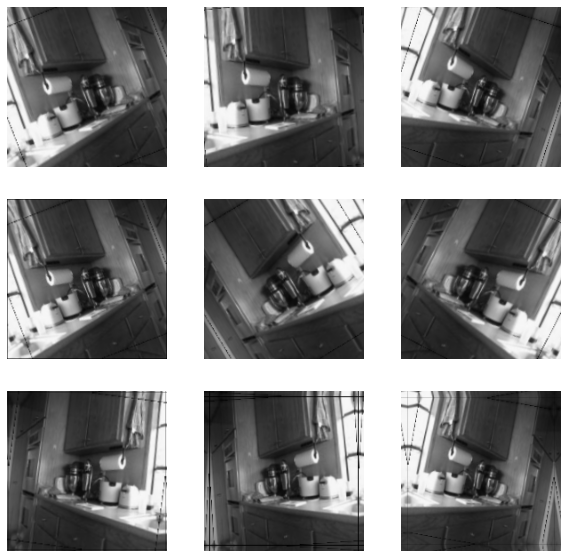

In [18]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

You will use data augmentation to train a model in a moment.

## Dropout

Another technique to reduce overfitting is to introduce Dropout to the network, a form of *regularization*.

In [19]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compile and train the model

In [20]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

In [22]:
epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
38/38 [==============================] - 1s 19ms/step - loss: 2.8400 - accuracy: 0.0775 - val_loss: 2.6949 - val_accuracy: 0.1667
Epoch 2/50
38/38 [==============================] - 1s 16ms/step - loss: 2.6322 - accuracy: 0.1300 - val_loss: 2.5010 - val_accuracy: 0.1767
Epoch 3/50
38/38 [==============================] - 1s 16ms/step - loss: 2.4718 - accuracy: 0.1992 - val_loss: 2.1996 - val_accuracy: 0.3033
Epoch 4/50
38/38 [==============================] - 1s 17ms/step - loss: 2.2873 - accuracy: 0.2742 - val_loss: 2.0777 - val_accuracy: 0.3500
Epoch 5/50
38/38 [==============================] - 1s 17ms/step - loss: 2.1220 - accuracy: 0.3067 - val_loss: 2.0579 - val_accuracy: 0.3467
Epoch 6/50
38/38 [==============================] - 1s 16ms/step - loss: 1.9651 - accuracy: 0.3758 - val_loss: 1.9474 - val_accuracy: 0.4133
Epoch 7/50
38/38 [==============================] - 1s 17ms/step - loss: 1.8574 - accuracy: 0.3900 - val_loss: 1.9682 - val_accuracy: 0.3933
Epoch 8/50
38

## Visualize training results

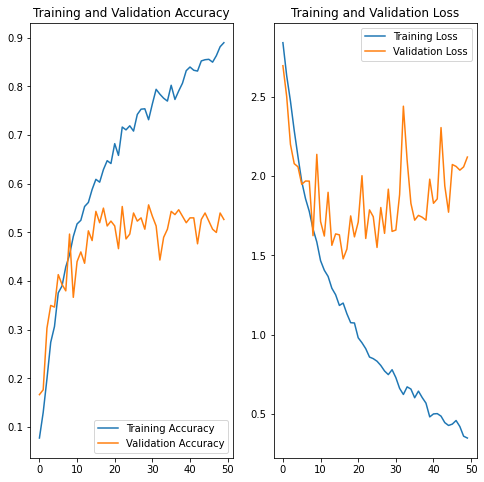

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## **Fine-tune ResNet50 for our dataset** 

#### Even after trying different combinations of Dropout, Maxpooling, different number of layers and different number of kernals, I got only 60 to 65% accuracy. So, to build a more efficient model, I tuned ResNet50 for our dataset

In [24]:
# Data Augmentation
train_datagen = ImageDataGenerator(horizontal_flip=True, brightness_range=[0.5,1.5], zoom_range=[0.8,1], rotation_range=5)

train_generator = train_datagen.flow_from_directory('../input/scene-data/hw5_data/train/',
                                                 target_size=(256,256),
                                                 batch_size=batch_size,
                                                 class_mode='sparse',
                                                 shuffle=True,
                                                 subset='training')

validation_datagen = ImageDataGenerator()

validation_generator = validation_datagen.flow_from_directory('../input/scene-data/hw5_data/test/',target_size=(256,256),
                                                 batch_size=batch_size,
                                                 class_mode='sparse')

Found 1500 images belonging to 15 classes.
Found 150 images belonging to 15 classes.


In [25]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

base_model_res = ResNet50(input_shape=(256, 256, 3), weights='imagenet', include_top=False)
x = GlobalAveragePooling2D()(base_model_res.output)
output = Dense(num_classes, kernel_initializer='zeros')(x)
model = Model(inputs=[base_model_res.input], outputs=[output])


# Training with the final custom-made layers
# ResNet 50 (48,51)
for layer in model.layers[:48]:
    layer.trainable =False
    
        
for layer in model.layers[48:]:
    layer.trainable=True
    
model.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
______________________

In [26]:
batch_size = 64  # Training batch size
num_classes = 15  # Classes in dataset
num_epochs = 40   # Epochs for training   
lr = 1e-3  # Learning rate
lr_weight_decay = 1e-3 
sgd = optimizers.SGD(lr=1e-3, momentum=0.9, decay=1e-3)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=sgd, loss=loss_fn, metrics=['accuracy'])


step_size_train = train_generator.n // train_generator.batch_size
step_size_val = validation_generator.n // validation_generator.batch_size

history = model.fit_generator(generator=train_generator, steps_per_epoch=step_size_train,
                              validation_data=validation_generator, validation_steps=step_size_val,
                              epochs=num_epochs)

Epoch 1/40
46/46 [==============================] - 28s 613ms/step - loss: 1.9538 - accuracy: 0.5286 - val_loss: 1.0482 - val_accuracy: 0.7188
Epoch 2/40
46/46 [==============================] - 26s 569ms/step - loss: 0.7570 - accuracy: 0.8610 - val_loss: 0.5764 - val_accuracy: 0.8203
Epoch 3/40
46/46 [==============================] - 27s 588ms/step - loss: 0.4393 - accuracy: 0.9046 - val_loss: 0.5341 - val_accuracy: 0.8281
Epoch 4/40
46/46 [==============================] - 26s 572ms/step - loss: 0.3040 - accuracy: 0.9339 - val_loss: 0.4309 - val_accuracy: 0.8750
Epoch 5/40
46/46 [==============================] - 27s 591ms/step - loss: 0.2477 - accuracy: 0.9394 - val_loss: 0.3776 - val_accuracy: 0.8516
Epoch 6/40
46/46 [==============================] - 26s 574ms/step - loss: 0.2023 - accuracy: 0.9516 - val_loss: 0.2711 - val_accuracy: 0.9141
Epoch 7/40
46/46 [==============================] - 27s 577ms/step - loss: 0.1628 - accuracy: 0.9564 - val_loss: 0.2572 - val_accuracy: 0.9062

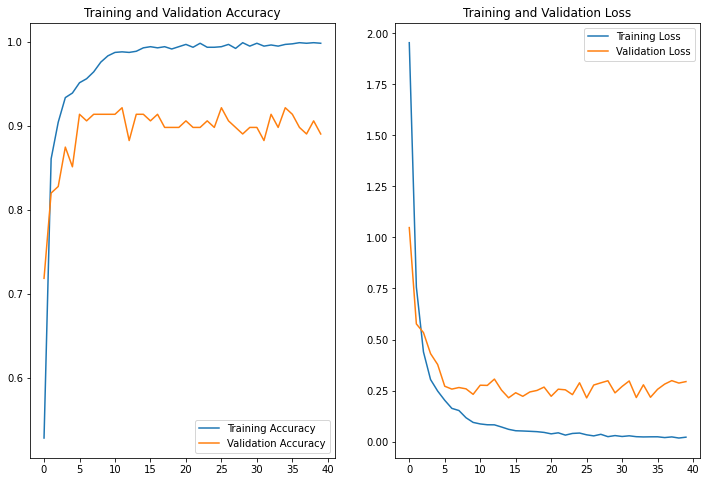

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(40)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predict on new data

Finally, let's use our model to classify an image that wasn't included in the training or validation sets.

This image most likely belongs to Store with a 100.00 percent confidence.


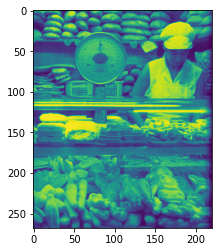

In [28]:
img_path = '../input/scene-data/hw5_data/test/Store/image_0040.jpg'
img = keras.preprocessing.image.load_img(
    img_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
img = mpimg.imread(img_path)
imgplot = plt.imshow(img)
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)